In [1]:
#세이지 메이커 최신 업데이트
!pip3 install -U sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import os
import boto3
import re
import sagemaker

#서비스를 이용하기 위한 권한 ,지역 , s3 주소 설정. 
role = sagemaker.get_execution_role() #권한 노트북 or 세이지메이커 세션에 연결된 권한으로 권한 연결
region = sagemaker.Session().boto_region_name #지역 지역 설정으로 boto가 연결된(사용할) 지역으로 지역 설정
bucket = sagemaker.Session().default_bucket() #버켓  기본 버켓 설정 버킷이름에 지역+사용자이름의 버킷을 자동생성

prefix = "5N/TEST5"

#s3이름은
#sagemaker-ap-northeast-2-197123..../5N/TEST5

In [3]:
#업로드
s3 = boto3.client("s3")
#s3에 파일 업로드
s3.upload_file("MackeyGlass_t17.txt", bucket, prefix + "/"+ "train/MackeyGlass_t17.txt")

pytorch ESN을 스크립트문 형식으로 바꿔주고 돌렸습니다.
Esnstack.py(raw)와 다른점은 XGBoost에서 설명드린 부분처럼 파라미터를 ArgumentParser로 받았고 추가적으로 데이터 타입을 변환한 부분(함수 def get_torch_func():)이 있습니다.
그리고 클래스의 def fit(self,input,output,epoch=100): 부분에서 마지막 확인은 epoch =100으로 기존 테스트와 동일하게 진행하였고 그 후에 epoch =3 변경해 놓았습니다.

In [4]:
%%writefile ./Esnstack.py

import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

import numpy as np
from scipy import linalg 
import torch
from sklearn.utils import check_array
import torch.nn as nn
import torch.optim as optim

def get_torch_func(name): # 파라미터 inter_unit 데이터 타입을 맞춰주기 위해서 만든 함수입니다.
    if name == 'tanh':
        return torch.tanh
    if name == 'sin':
        return torch.sin
    else:
        raise ValueError('Invalid function name')
        

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')

class ESN(nn.Module):
    def __init__(self, args):
        super(ESN, self).__init__()
        
        #파라미터를 args 받습니다.
        inter_unit1 = get_torch_func(args.inter_unit)
        
        self.resSize = args.resSize # reservoir weight's size
        self.n_readout =args.n_readout # number of readouts
        self.damping = args.damping  # How much to reflect previous data
        self.spectral_radius = args.spectral_radius # It must be less than 1. The default can be obtained through Eigen value.
        self.weight_scaling = args.weight_scaling
        self.initLen=args.initLen # esn의 메모리 효과를 학습을 위한 길이 설정
        self.random_state = args.random_state # value of random seed
        self.inter_unit = inter_unit1 ## 내부에서 사용할 함수
        self.zero_per = args.zero_per # Zero abundance of reservoir weight
        self.learning_rate = args.learning_rate # learning rate
        torch.manual_seed(args.random_state) # fix random seed value 
        self.out = None # Stores the last value of the input for generative mode
        self.l_a = args.l_a # learning argorithm
        self._init(args.n_feature) # 고정된 Win, W, Wout을 initialize here
        
    def _init(self,n_feature):
        with torch.no_grad():
            self.one = torch.DoubleTensor([[1]]).to(device)
            # 아래는 W와 ,Win을 sparse 하게 구현하기 위한 알고리즘
            num_zeros = int(self.resSize * self.resSize * self.zero_per)
            values = torch.cat((torch.zeros(num_zeros, dtype=torch.double), torch.rand(self.resSize * self.resSize - num_zeros,dtype=torch.double) * 2 - 1))
            perm = torch.randperm(self.resSize * self.resSize)
            values = values[perm]
            W = values.view(self.resSize, self.resSize)
            
            
            num_zeros = int(self.resSize*(1+n_feature)*self.zero_per)
            values = torch.cat((torch.zeros(num_zeros, dtype=torch.double), torch.rand(self.resSize * (1+n_feature) - num_zeros, dtype=torch.double) * 2 - 1))
            perm = torch.randperm((1+n_feature) * self.resSize )
            values = values[perm]
            self.Win = values.view(1+n_feature, self.resSize)
            self.Win=nn.Parameter(self.Win.to(device))
        print('Computing spectral radius...')
        
        
         # 가중치 업데이트 과정 -> weight_scaling 값으로 나눈 값으로 가중치를 업데이트함. -> weight_scaling은 가중치 학습률이다.
        rhoW = max(abs(linalg.eig(W)[0]))
        if self.spectral_radius == 0:
            self.W= W*(self.weight_scaling/rhoW)
        else:
            self.W= W*(self.weight_scaling/self.spectral_radius) #spectral_radius = max(abs(linalg.eig(W)[0]))  default
        self.W=nn.Parameter(self.W.to(device))
        self.Wout = nn.Parameter(torch.rand(1+n_feature+self.resSize , self.n_readout, dtype=torch.double,requires_grad=True).to(device))
        print('done.')
        
    def fit(self,input,output,epoch=3): #input data를 입력하면 output을 regression 할 수 있도록 학습
   
        if input.ndim==1: # input의 shape을 확인 하고 학습에 적당한 형태로 변환
            input=input.reshape(-1,1)
        input = check_array(input, ensure_2d=True)
        
        if output.ndim==1:  # output의 shape을 확인 하고 학습에 적당한 형태로 변환
            output=output.reshape(-1,1)
        output = check_array(output, ensure_2d=True)
        n_input, n_feature= input.shape
        
            
        Yt=torch.tensor(output[self.initLen: , :],dtype=torch.double, device=device, requires_grad=False) #target data
        
        self.out = input[n_input-1,:] # Stores the last value of the input for generative mode
        
        
        
        if self.l_a == "gd": # gd를 이용한 Wout을 학습하는 esn
            
            criterion = torch.nn.MSELoss()
            parameters=[self.Wout]
            optimizer = optim.Adam(parameters, self.learning_rate)


            for i in range(epoch): 
                # x는 reservoir weight로 time step에 따라 변함
                x = torch.zeros((1,self.resSize),requires_grad = False).type(torch.double).to(device) # 매 에포크 마다 초기화, x의 크기는 n_레저버 * 1
                Y = torch.zeros((n_input-self.initLen , self.n_readout),requires_grad = False).type(torch.double).to(device) # prediction data
                for t in range(n_input):

                    u = torch.tensor(np.array(input[t,:].reshape(1,-1)), dtype=torch.double, device=device, requires_grad=False)
                    x = (1-self.damping)*x + self.damping*self.inter_unit( torch.matmul(torch.hstack([self.one,u]), self.Win)  + torch.matmul( x,self.W ) )
                    y = torch.matmul(torch.hstack([self.one,u,x]), self.Wout)
                    if t >= self.initLen:
                        Y[t-self.initLen, :] = y.reshape(-1)

                loss = criterion(Y,Yt) 
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 
                print("epoch: {}, lost:{}".format(i,loss.item()))
                del x, Y,y,u
                torch.cuda.empty_cache()
               
            
        elif self.l_a =="inverse_matrix": # inver matrix를 이용한 기존 esn
         
            
            
            X = torch.zeros((n_input-self.initLen,1+n_feature+self.resSize),dtype = torch.double, device=device)
            x = torch.zeros((1,self.resSize),requires_grad = False).type(torch.double).to(device) # x의 크기는 n_레저버 * 1
            for t in range(n_input):
                u = torch.tensor(np.array(input[t,:].reshape(1,-1)), dtype=torch.double, device=device) # input에서 값을 하나씩 들고온다

                x = (1-self.damping)*x + self.damping*self.inter_unit( torch.matmul(torch.hstack([self.one,u]), self.Win)  + torch.matmul( x, self.W ) )
                    # x에 전체노드에서 소실률에 의거해 위의 식에 따라 계산된 weight값을 저장한다 
                if t >= self.initLen:
                    X[t-self.initLen, :] = torch.hstack([self.one,u,x])[0,: ]  # X에 1,u,x를 쌓아 저장한다 
                    
                self.X=X
                self.x=x # genereative mode에 필요해서 저장
                self.out = input[n_input-1, :] #generative mode를 위한 input의 last value를 저장

                #### train the output by ridge regression
                # reg = 1e-8  # regularization coefficient
                #### direct equations from texts:
                # X_T = X.T
                # Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
                # reg*np.eye(1+inSize+resSize) ) )
                # using scipy.linalg.solve:
                # inverse matrix를 이용한 ridge regression을 이용하여 Wout을 구할 수 있음
                reg = 1e-8
                self.Wout = nn.Parameter(torch.linalg.solve(torch.matmul(self.X.T,self.X) + reg*torch.eye(1+n_feature+self.resSize).to(device), torch.matmul(Yt.T,X).T))

                
                
        return self    
    
        
    def predict(self,input):    
        #Use after learning Wout first. After fixing Wout, input data can be predicted without learning
        if input.ndim==1:
            input=input.reshape(-1,1)
        input = check_array(input, ensure_2d=True)
        x = torch.zeros((1,self.resSize),requires_grad = False).type(torch.double).to(device) # x의 크기는 n_레저버 * 1  
        n_input,n_feature, = input.shape
        Y = torch.zeros((n_input,self.n_readout)).type(torch.double).to(device)

        for t in range(n_input):
            u=torch.tensor(np.array(input[t,:].reshape(1,-1)),dtype=torch.double, device=device, requires_grad=False)
            x = (1-self.damping)*x + self.damping*self.inter_unit( torch.matmul(torch.hstack([self.one,u]), self.Win)  + torch.matmul( x, self.W ) )
            y = torch.matmul(torch.hstack([self.one,u,x]), self.Wout) 
         
            Y[t-self.initLen , :] = y.reshape(-1)
        return Y 

    
    
    
    
def parse_args():
    parser = argparse.ArgumentParser()
    print("extracting arguments")

    parser.add_argument("--resSize", type=int, default=1500)
    parser.add_argument("--n_readout", type=int, default=1)
    parser.add_argument("--damping", type=float, default=0.3)
    parser.add_argument("--spectral_radius", type=int, default=0)
    parser.add_argument("--weight_scaling", type=float, default=1.25)
    parser.add_argument("--random_state", type=int, default=42)
    parser.add_argument("--inter_unit", type=str, default='tanh')
    parser.add_argument("--zero_per", type=float, default=0.9994)
    parser.add_argument("--initLen", type=int, default=0)
    parser.add_argument("--learning_rate", type=float, default=1e-1)
    parser.add_argument("--l_a", type=str, default='gd')
    parser.add_argument("--n_feature", type=int, default=1)
    


    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))

    args, _ = parser.parse_known_args()
    
    return args


if __name__ == "__main__":

    args = parse_args()
    
    df = np.loadtxt(os.path.join(args.train,'MackeyGlass_t17.txt'))
    
    #fit() 진행 후 모델 저장
    model = ESN(args)
    model.fit(df[:1000],df[:1000])
    model_location = args.model_dir + '/model.pth'
    torch.save(model.state_dict(), model_location)
    

Overwriting ./Esnstack.py


In [5]:
#파라미터
hyperparams = {
    "resSize": "1500",
    "n_readout": "1",
    "damping":"0.3",
    "spectral_radius": "0",
    "weight_scaling": "1.25",
    "random_state": "42",
    "inter_unit": "tanh",
    "zero_per": "0.9994",
    "initLen": "0",
    "learning_rate": "1e-1",
    "l_a":"gd",
    "n_feature":"1"
}


instance_type = "ml.m5.2xlarge"
output_path = "s3://{}/{}/{}/output".format(bucket, prefix, "result")
#4N/TEST/result/...
content_type = "txt"

In [6]:
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.pytorch import PyTorch

pytorch_estimator = PyTorch(entry_point='Esnstack.py',
                            framework_version="2.0",
                            py_version="py310",
                            hyperparameters=hyperparams,
                            role=role,
                            instance_count=1,
                            instance_type='ml.c4.xlarge',
                            output_path=output_path)

train_input = TrainingInput(
    "s3://{}/{}/{}/".format(bucket, prefix, "train"), content_type=content_type
)

In [7]:
pytorch_estimator.fit({"train":train_input})

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-08-18-05-07-43-291


2023-08-18 05:07:43 Starting - Starting the training job...
2023-08-18 05:07:58 Starting - Preparing the instances for training......
2023-08-18 05:09:09 Downloading - Downloading input data...
2023-08-18 05:09:29 Training - Downloading the training image.........
2023-08-18 05:11:00 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-18 05:11:03,555 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-18 05:11:03,556 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-08-18 05:11:03,556 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-18 05:11:03,570 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-18 05:11:03,574 sagemaker_pytorch_container.training INFO     Invoking user trai

In [8]:
#S3에서 모델을 다운로드
s3.download_file(bucket, prefix+"/result/output/"+"pytorch-training-2023-08-18-05-07-43-291"+"/output/model.tar.gz", "./model.tar.gz")

In [9]:
import tarfile

with tarfile.open('model.tar.gz', 'r:gz') as file:
    file.extractall(path='model/')


모델과 Esnstack.py(raw) 가지고 predict()

In [10]:
import numpy as np
from scipy import linalg 
import torch
from sklearn.utils import check_array
import torch.nn as nn
import torch.optim as optim


USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')

class ESN(nn.Module):
    def __init__(self, n_readout, 
                 resSize=1500, damping=0.3, spectral_radius=None,
                 weight_scaling=1.25,initLen=0, random_state=42,inter_unit=torch.tanh, learning_rate=1e-1,zero_per = 0.9994, l_a = 'gd',n_feature = 1):
        super(ESN, self).__init__()
        
        self.resSize = resSize # reservoir weight's size
        self.n_readout =n_readout # number of readouts
        self.damping = damping  # How much to reflect previous data
        self.spectral_radius = spectral_radius # It must be less than 1. The default can be obtained through Eigen value.
        self.weight_scaling = weight_scaling
        self.initLen=initLen # esn의 메모리 효과를 학습을 위한 길이 설정
        self.random_state = random_state # value of random seed
        self.inter_unit = inter_unit ## 내부에서 사용할 함수
        self.zero_per = zero_per # Zero abundance of reservoir weight
        self.learning_rate = learning_rate # learning rate
        torch.manual_seed(random_state) # fix random seed value 
        self.out = None # Stores the last value of the input for generative mode
        self.l_a = l_a # learning argorithm
        self._init(n_feature) # 고정된 Win, W, Wout을 initialize here
        
    def _init(self,n_feature):
        with torch.no_grad():
            self.one = torch.DoubleTensor([[1]]).to(device)
            # 아래는 W와 ,Win을 sparse 하게 구현하기 위한 알고리즘
            num_zeros = int(self.resSize * self.resSize * self.zero_per)
            values = torch.cat((torch.zeros(num_zeros, dtype=torch.double), torch.rand(self.resSize * self.resSize - num_zeros,dtype=torch.double) * 2 - 1))
            perm = torch.randperm(self.resSize * self.resSize)
            values = values[perm]
            W = values.view(self.resSize, self.resSize)
            
            
            num_zeros = int(self.resSize*(1+n_feature)*self.zero_per)
            values = torch.cat((torch.zeros(num_zeros, dtype=torch.double), torch.rand(self.resSize * (1+n_feature) - num_zeros, dtype=torch.double) * 2 - 1))
            perm = torch.randperm((1+n_feature) * self.resSize )
            values = values[perm]
            self.Win = values.view(1+n_feature, self.resSize)
            self.Win=nn.Parameter(self.Win.to(device))
        print('Computing spectral radius...')
        
        
         # 가중치 업데이트 과정 -> weight_scaling 값으로 나눈 값으로 가중치를 업데이트함. -> weight_scaling은 가중치 학습률이다.
        rhoW = max(abs(linalg.eig(W)[0]))
        if self.spectral_radius == None:
            self.W= W*(self.weight_scaling/rhoW)
        else:
            self.W= W*(self.weight_scaling/self.spectral_radius) #spectral_radius = max(abs(linalg.eig(W)[0]))  default
        self.W=nn.Parameter(self.W.to(device))
        self.Wout = nn.Parameter(torch.rand(1+n_feature+self.resSize , self.n_readout, dtype=torch.double,requires_grad=True).to(device))
        print('done.')
        
    def fit(self,input,output,epoch=3): #input data를 입력하면 output을 regression 할 수 있도록 학습
   
        if input.ndim==1: # input의 shape을 확인 하고 학습에 적당한 형태로 변환
            input=input.reshape(-1,1)
        input = check_array(input, ensure_2d=True)
        
        if output.ndim==1:  # output의 shape을 확인 하고 학습에 적당한 형태로 변환
            output=output.reshape(-1,1)
        output = check_array(output, ensure_2d=True)
        n_input, n_feature= input.shape
        
            
        Yt=torch.tensor(output[self.initLen: , :],dtype=torch.double, device=device, requires_grad=False) #target data
        
        self.out = input[n_input-1,:] # Stores the last value of the input for generative mode
        
        
        
        if self.l_a == "gd": # gd를 이용한 Wout을 학습하는 esn
            
            criterion = torch.nn.MSELoss()
            parameters=[self.Wout]
            optimizer = optim.Adam(parameters, self.learning_rate)


            for i in range(epoch): 
                # x는 reservoir weight로 time step에 따라 변함
                x = torch.zeros((1,self.resSize),requires_grad = False).type(torch.double).to(device) # 매 에포크 마다 초기화, x의 크기는 n_레저버 * 1
                Y = torch.zeros((n_input-self.initLen , self.n_readout),requires_grad = False).type(torch.double).to(device) # prediction data
                for t in range(n_input):

                    u = torch.tensor(np.array(input[t,:].reshape(1,-1)), dtype=torch.double, device=device, requires_grad=False)
                    x = (1-self.damping)*x + self.damping*self.inter_unit( torch.matmul(torch.hstack([self.one,u]), self.Win)  + torch.matmul( x,self.W ) )
                    y = torch.matmul(torch.hstack([self.one,u,x]), self.Wout)
                    if t >= self.initLen:
                        Y[t-self.initLen, :] = y.reshape(-1)

                loss = criterion(Y,Yt) 
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 
                print("epoch: {}, lost:{}".format(i,loss.item()))
                del x, Y,y,u
                torch.cuda.empty_cache()
               
            
        elif self.l_a =="inverse_matrix": # inver matrix를 이용한 기존 esn
         
            
            
            X = torch.zeros((n_input-self.initLen,1+n_feature+self.resSize),dtype = torch.double, device=device)
            x = torch.zeros((1,self.resSize),requires_grad = False).type(torch.double).to(device) # x의 크기는 n_레저버 * 1
            for t in range(n_input):
                u = torch.tensor(np.array(input[t,:].reshape(1,-1)), dtype=torch.double, device=device) # input에서 값을 하나씩 들고온다

                x = (1-self.damping)*x + self.damping*self.inter_unit( torch.matmul(torch.hstack([self.one,u]), self.Win)  + torch.matmul( x, self.W ) )
                    # x에 전체노드에서 소실률에 의거해 위의 식에 따라 계산된 weight값을 저장한다 
                if t >= self.initLen:
                    X[t-self.initLen, :] = torch.hstack([self.one,u,x])[0,: ]  # X에 1,u,x를 쌓아 저장한다 
                    
                self.X=X
                self.x=x # genereative mode에 필요해서 저장
                self.out = input[n_input-1, :] #generative mode를 위한 input의 last value를 저장

                #### train the output by ridge regression
                # reg = 1e-8  # regularization coefficient
                #### direct equations from texts:
                # X_T = X.T
                # Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
                # reg*np.eye(1+inSize+resSize) ) )
                # using scipy.linalg.solve:
                # inverse matrix를 이용한 ridge regression을 이용하여 Wout을 구할 수 있음
                reg = 1e-8
                self.Wout = nn.Parameter(torch.linalg.solve(torch.matmul(self.X.T,self.X) + reg*torch.eye(1+n_feature+self.resSize).to(device), torch.matmul(Yt.T,X).T))

                
                
        return self    
    
        
    def predict(self,input):    
        #Use after learning Wout first. After fixing Wout, input data can be predicted without learning
        if input.ndim==1:
            input=input.reshape(-1,1)
        input = check_array(input, ensure_2d=True)
        x = torch.zeros((1,self.resSize),requires_grad = False).type(torch.double).to(device) # x의 크기는 n_레저버 * 1  
        n_input,n_feature, = input.shape
        Y = torch.zeros((n_input,self.n_readout)).type(torch.double).to(device)

        for t in range(n_input):
            u=torch.tensor(np.array(input[t,:].reshape(1,-1)),dtype=torch.double, device=device, requires_grad=False)
            x = (1-self.damping)*x + self.damping*self.inter_unit( torch.matmul(torch.hstack([self.one,u]), self.Win)  + torch.matmul( x, self.W ) )
            y = torch.matmul(torch.hstack([self.one,u,x]), self.Wout) 
         
            Y[t-self.initLen , :] = y.reshape(-1)
        return Y 
    

In [11]:
model = ESN(n_readout = 1, damping=0.3, spectral_radius=None,
                 weight_scaling=1.25,initLen=0, random_state=42,inter_unit=torch.tanh, learning_rate=1e-1,zero_per = 0.9996, l_a = 'gd',n_feature = 1) 

Computing spectral radius...
done.


In [12]:
import torch

model.load_state_dict(torch.load('model/model.pth')) #사용가능

<All keys matched successfully>

In [13]:
import numpy as np

df = np.loadtxt("MackeyGlass_t17.txt")

In [14]:
y_pred = model.predict(df[0:1000])

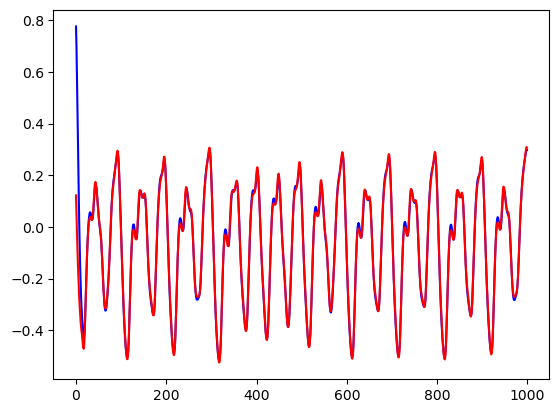

In [15]:
import matplotlib.pyplot as plt

plt.plot(y_pred.cpu().detach().numpy(),'b')
plt.plot(df[:1000],'r')
plt.show()